## Outline
1. Import libraries and initialise global variables
2. Load data
3. Data augmentation
4. Load base models
5. Model creation using transfer learning
    - Base models (from step 4) are used here
6. Model training
2. Build models for all sets
    - Call gen_models_all_sets()
3. Model Analysis
    - Get model statistics
4. Findings and results

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from gen_results import gen_save_cr_cm # Load test results

from tqdm import tqdm            # Progress bar
from pathlib import Path         # Create new folder if does not exist

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import json
import ssl

# Set if memory growth should be enabled for a PhysicalDevice.
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
# Initialise global variables
BATCH_SIZE = 64
EPOCHS = 500
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
LABELS = ["female", "male"]
set_nums = [1,5,8,10]            # List of set numbers

In [ ]:
# Load train dataset
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
# Load validation dataset
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

In [ ]:
# Data augmentation
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Load MobileNetV3 Large base model
preprocess_input_mobile = tf.keras.applications.mobilenet_v3.preprocess_input
base_model_mobile = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
# Load DenseNet 201 base model
preprocess_input_dense = tf.keras.applications.densenet.preprocess_input
base_model_dense = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')
# Load ResNet50 base model
preprocess_input_res = tf.keras.applications.resnet50.preprocess_input
base_model_res = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                           include_top=False,
                                           weights='imagenet')

## Model Creation

In [ ]:
def create_model(base_model, preprocess_input):
    global train_dataset
    
    # Converts images into a 5x5x1280 block of features
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    
    # Freeze all convolutional base
    base_model.trainable = False
    
    # Add classification head
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    # Model building
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, kernel_regularizer='l2', activation='relu')(x)
    x = tf.keras.layers.Dense(1024, kernel_regularizer='l2', activation='relu')(x)
    x = tf.keras.layers.Dense(512, kernel_regularizer='l2', activation='relu')(x)
    outputs = keras.layers.Dense(1,activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [ ]:
# Create the three different models
model_mobile = create_model(base_model_mobile, preprocess_input_mobile)
model_dense = create_model(base_model_dense, preprocess_input_dense)
model_res = create_model(base_model_res, preprocess_input_res)

## Model Training

In [ ]:
def model_training(model, set_no, suffix):
    """
    Trains model, and saves model's best weights and history
    
    set_no: int
        Set number
    """
    checkpoint = ModelCheckpoint(
        "best_weights/set{}/model_tl_best_weights_{}_set{}.h5".format(set_no, suffix, set_no),
        monitor="loss",
        verbose=0,
        save_best_only=True,
        mode="min",
        save_freq="epoch",
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5,
                                                     mode='max')
    
    # Save a checkpoint of the model for later use
    start_time = time.time()
    history = model.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=validation_dataset,
                            callbacks=[checkpoint, early_stopping])
    time_taken = "%.2fs" % (time.time() - start_time)
    history.history['time_taken'] = time_taken

    
    target = "history/set{}".format(str(set_no)) # Store model history as a JSON file
    with open(os.path.join(target, "model_tl_history_{}_set{}.json".format(suffix, set_no)), "w") as f:
        json.dump(history.history, f) # Construct the baseline (unperturbed) model
        
    return history

In [ ]:
def find_best_weights_and_history(set_no):
    """
    Gets model best weights from training and history
    
    set_no : int
        Set number
    """
    history_mobile = model_training(model_mobile,  set_no, 'mobile')
    history_dense = model_training(model_dense, set_no, 'dense')
    history_res = model_training(model_res, set_no, 'res')

In [14]:
def gen_models_all_sets(debiased=False, EPOCHS=EPOCHS):
    """
    This function does two things:
    1. Builds all three model types (MobileNet, ResNet50, DenseNet)
    2. Saves model with the best weights and history
    
    debiased : boolean
        Determines whether we are training a debiased model or not
    EPOCHS : int
        Number of epochs
    """
    for set_no in tqdm(set_numbers, "Loading models..."):
        print("Training...")
        find_best_weights_and_history(set_no)
        print("Saving...")
        print("--------------------------------")

In [16]:
# gen_models_all_sets()

Loading models...:   0%|          | 0/1 [00:00<?, ?it/s]

Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23063 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/500
721/721 [==============================] - 38s 50ms/step - loss: 5.9861 - accuracy: 0.7391 - val_loss: 0.8925 - val_accuracy: 0.7879
Epoch 2/500
721/721 [==============================] - 35s 49ms/step - loss: 0.6950 - accuracy: 0.7980 - val_loss: 0.4985 - val_accuracy: 0.7940
Epoch 3/500
721/721 [==============================] - 35s 49ms/step - loss: 0.4430 - accuracy: 0.8113 - val_loss: 0.4582 - val_accuracy: 0.7984
Epoch 4/500
721/721 [==============================] - 35s 49ms/step - loss: 0.4000 - accuracy: 0.8154 - val_loss: 0.4340 - val_accuracy: 0.7973
Epoch 5/500
721/721 [==============================] - 35s 49ms/step - loss: 0.3828 - accuracy: 0.8222 - val_loss: 0.4508 - val_accuracy: 0.7973
Epoch 6/500
721/721 [==============================] - 35s 49ms/s

Loading models...: 100%|██████████| 1/1 [12:38:56<00:00, 45536.16s/it]

Saving...
--------------------------------


# Model Analysis

In [2]:
def get_all_models(set_no, best_w_fp="best_weights/"):
    """
    Returns a list of Keras models from a specific set 
    
    set_no : int
        Set number
    best_w_fp : str
        File path where the best weights of the models for the particular set is stored
    """
    target = best_w_fp + "set" + str(set_no) + "/"
    mobilenet = tf.keras.models.load_model(target + 'model_tl_best_weights_mobile_set{}.h5'.format(str(set_no)))
    densenet = tf.keras.models.load_model(target + 'model_tl_best_weights_dense_set{}.h5'.format(str(set_no)))
    resnet = tf.keras.models.load_model(target + 'model_tl_best_weights_res_set{}.h5'.format(str(set_no)))
    all_models = [mobilenet, densenet, resnet]
    return all_models

In [ ]:
def gen_result_for_sets(all_models, original, target):
    """
    Call this function to generate Classification Reports and confusion Matrix results
    
    all_models : list
        List of Keras models
    original : str
        Original file path
    target : str
        Target file path
    """
    # Classification reports and confusion matrices for MobileNet
    cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', all_models, original, target, perturbation=test_type, gender=None) # Both
    # Classification reports and confusion matrices for DenseNet
    cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', all_models, original, target, perturbation=test_type, gender=None) # Both
    # Classification reports and confusion matrices for ResNet
    cr_res_all, cm_res_all = gen_save_cr_cm('res', all_models, original, target, perturbation=test_type, gender=None) # Both

In [17]:
def gen_cr_cm_results(original_folder = "preprocessing/cv_datasets/", target_folder = "cr_cm_results/"):
    """
    Generates cr_cm_results
    
    original_folder : str
        File path to folder containing original image
    target_folder : str
        File path to folder to store classification report (CR) and confusion matrix (CM)
    """
    for i in tqdm(range(len(set_nums)), "Generating results..."):
        set_no = set_nums[i]
        original = original_folder + "set" + str(set_no) + "/"       # Where is it coming from?
        target = target_folder + "set" + str(set_no) + "/"           # Where do you want to store the results?
        Path(target).mkdir(parents=True, exist_ok=True)              # Make new directory if empty
        all_models = get_all_models(set_no)                          # Grab all models, MobileNet, DenseNet, ResNet50
        gen_result_for_sets(all_models, original, target)

In [43]:
def load_metrics(model_type, target_folder, perturbation='ori'):
    """
    Loads in results from folder fyp-ma-13/fyp-models/cr_cm_results
    
    model_type : str
        Either 'mobile' (MobileNet), 'dense' (DenseNet) or 'res' (ResNet50)
    target_folder : str
        Target folder name from timeline 
    perturbation: str
        Either 'ori', 'masked', 'glasses', or 'make_up'
    """
    assert perturbation in ['ori', 'masked', 'glasses', 'make_up']
    
    with open("timeline/{}/cr_cm_results/set10/cr_cm_{}_{}_{}".format(target_folder, model_type, perturbation, 'bothg')) as json_file:
        data = json.load(json_file)
        data = json.loads(data)
    return data

In [44]:
# gen_cr_cm_results(test_type="ori", original_folder = "preprocessing/cv_datasets_debiased/", target_folder = "cr_cm_results/")

In [250]:
def calculate_sum_cm(cm):
    """
    Gets total number of observations of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    res = 0
    for i in data_mobile_both['cm_mobile_all']:
        res += sum(i)
    return res

def calculate_acc_cm(cm):
    """
    Gets total accuracy of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    tot = calculate_sum_cm(cm)
    tn = cm[0][0]
    tp = cm[1][1]
    return ((tn+tp)/tot)*100

def calculate_female_acc(cm):
    """
    Gets female accuracy of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    female_row = cm[0]
    return (female_row[0] / (female_row[0] + female_row[1]))*100
    
def calculate_male_acc(cm):
    """
    Gets male accuracy of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    male_row = cm[1]
    return (male_row[1] / (male_row[0] + male_row[1]))*100

def calculate_precision(cm):
    """
    Gets precision of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    return 100*cm[1][1]/(cm[0][1]+cm[1][1])

def calculate_recall(cm):
    """
    Gets recall of input confusion matrix
    
    cm : list
        Confusion matrix
    """
    return 100*cm[1][1]/(cm[1][0]+cm[1][1])

In [122]:
# Load results
data_mobile_both = load_metrics('mobile', debiased_fp)
data_dense_both = load_metrics('dense', debiased_fp)
data_res_both = load_metrics('res', debiased_fp)

In [356]:
def gen_stats_graph(data, history, model_type, debiased=False):
    """
    This function does two things:
        1. Generate plot showing model statistics and show
        2. Saves generated plotƒ
        
    data : dict
        Dictionary containing data on classification report and confusion matrix
    history : dict
        History of the model
    model_type : str
        Model type
    debiased : boolean
        Determines whether we are targetting a debiased or not
    """
    key = f'cm_%s_bothg' % model_type     # Key to access confusion matrix data from "data"
    
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc += history['accuracy']
    val_acc += history['val_accuracy']

    loss += history['loss']
    val_loss += history['val_loss']
    
    plt.figure(figsize=(14, 8))
    plt.subplots_adjust(wspace=0.7, hspace= 0.4)

# ------------------------------------------------------------------------------------------------------------------
#   Plot accuracy training/validation graph
    plt.subplot(212)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

# ------------------------------------------------------------------------------------------------------------------
#   Plot confusion metric values
    plt.subplot(222)
    cols_barh = ['Male Accuracy', 'Female Accuracy', 'Precision', 'Recall', 'Gender Bias Index']
    
    
    cm = data[key]
    m_acc = round(calculate_male_acc(cm), 2)
    f_acc = round(calculate_female_acc(cm), 2)
    vals_barh = [m_acc, 
                 f_acc, 
                 round(calculate_precision(cm), 2),
                 round(calculate_recall(cm), 2),
                 round(f_acc - m_acc,2)]
    
    plt.barh(cols_barh, vals_barh)
    for index, value in enumerate(vals_barh):
        plt.text(value+0.3, index-0.2, str(value), fontweight='bold', ha='left',fontdict=dict(fontsize=12))
    
# ------------------------------------------------------------------------------------------------------------------
#   Plot confusion matrix
    plt.subplot(221)
    kw = key[3:].split('_')
    # Update title
    f = kw[0]
    if f == 'mobile':
        kw[0] = "MobileNet"
    elif f == 'dense':
        kw[0] = 'DenseNet'
    elif f == 'res':
        kw[0] = 'ResNet50'
    
    if kw[1] == 'all':
        kw[1] = 'both'
    kw = kw[0]
    cf_matrix = np.array(cm)
    
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = map(round, cf_matrix.flatten())
    group_percentages = (
        f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
    )
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"
    labels = np.asarray(["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]).reshape(2, 2)

    plt.suptitle(kw, fontsize = 30, ha='center')
    
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(
        df_cm,
        annot=labels,
        annot_kws={"size": 15},
        cmap="YlOrBr",
        fmt="",
        xticklabels=LABELS,
        yticklabels=LABELS,
    )
    sns.set_style("darkgrid")
    
    plt.savefig(f'stats_diagrams/%s_stats_graph.png' % model_type)
    plt.show()

In [359]:
# Load histories
baseline_fp = "(5)_early_stopping_20"
debiased_fp = "(7)_debiased_50"

with open(f'timeline/%s/history/set10/model_tl_history_mobile_set10.json' % baseline_fp) as f:
    history_mobile = json.load(f)
with open(f'timeline/%s/history/set10/model_tl_history_dense_set10.json' % baseline_fp) as f:
    history_dense = json.load(f)
with open(f'timeline/%s/history/set10/model_tl_history_res_set10.json' % baseline_fp) as f:
    history_res = json.load(f)

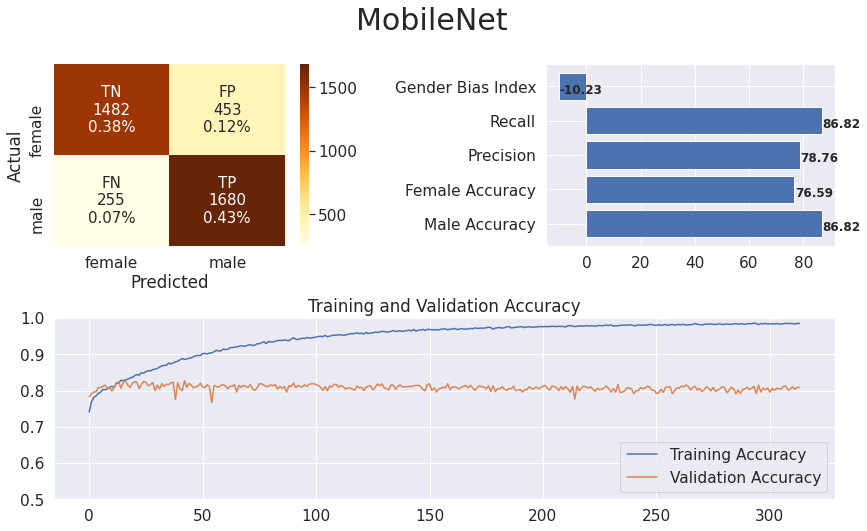

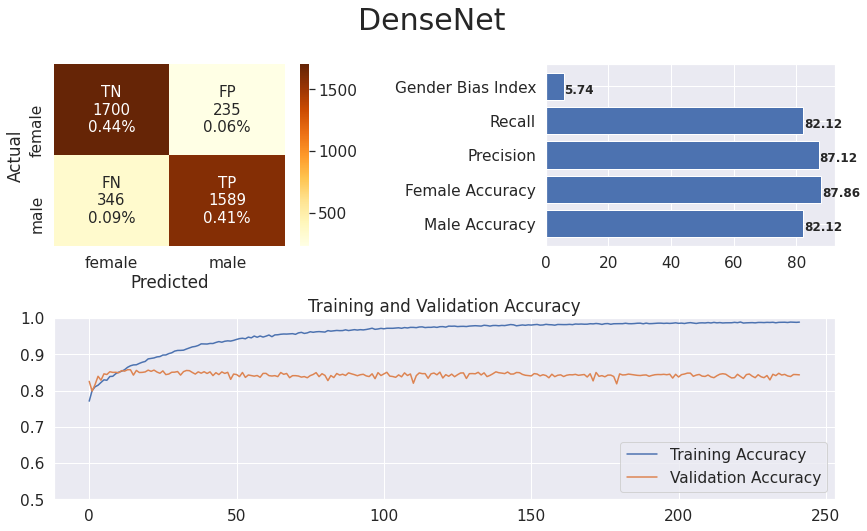

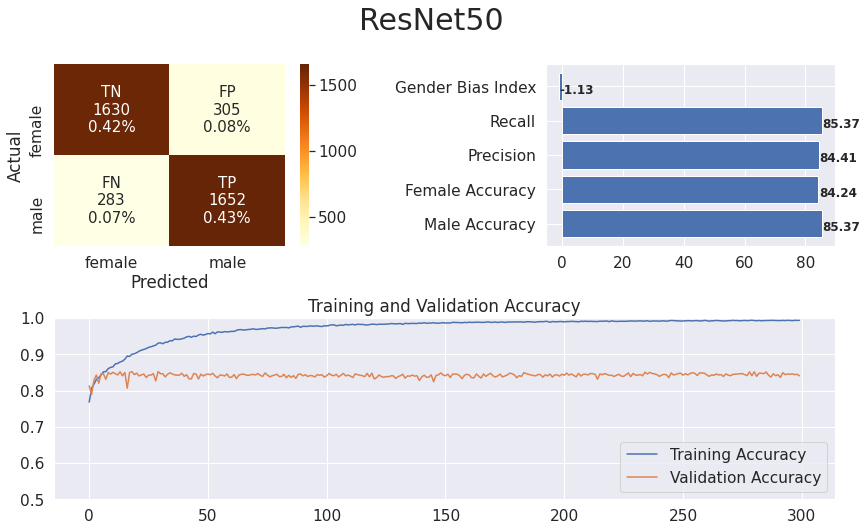

In [360]:
# Show statistics for baseline models
gen_stats_graph(data_mobile_both, "cm_mobile_bothg", history_mobile, 'mobile')                   # Accuracy and Loss graphs for MobileNet
gen_stats_graph(data_dense_both, "cm_dense_bothg", history_dense, 'dense')                       # Accuracy and Loss graphs for DenseNet
gen_stats_graph(data_res_both, "cm_res_bothg", history_res, 'res')                               # Accuracy and Loss graphs for ResNet50

# Show statistics for debiased models
gen_stats_graph(data_mobile_both, "cm_mobile_bothg", history_mobile, 'mobile', debiased=True)    # Accuracy and Loss graphs for MobileNet
gen_stats_graph(data_dense_both, "cm_dense_bothg", history_dense, 'dense', debiased=True)        # Accuracy and Loss graphs for DenseNet
gen_stats_graph(data_res_both, "cm_res_bothg", history_res, 'res', debiased=True)                # Accuracy and Loss graphs for ResNet50

# Findings
- Makeup improves accuracy when predicting females
- Makeup degrades accuracy of male classification quite significantly
- Masks generally degrade accuracy
- Masks degrade the accuracy of female classification harder compared to male